<a href="https://colab.research.google.com/github/ArttuLe/Image_colorization_v1/blob/main/Image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from skimage.color import rgb2lab

from keras.preprocessing.image import  img_to_array, load_img

In [3]:
!unzip -uq "/content/drive/MyDrive/Train.zip" -d "/content/sample_data/Train_images/"

In [4]:
!unzip -uq "/content/drive/MyDrive/Test.zip" -d "/content/sample_data/Test_images/"

Load images


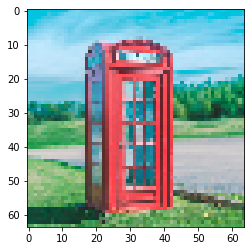

In [4]:

size = (64,64)
folder="/content/sample_data/Train_images/Train/"
train_images = []

for filename in os.listdir(folder):
  train_images.append(load_img(os.path.join(folder,filename), target_size=size))
imshow(train_images[23])
  

Convert each image in the array into numpy arrays

In [5]:
train_data = []

for img in train_images:
  train_data.append(img_to_array(img))

train_data = np.array(train_data, dtype=float)
def MinMax(train_data,labels=["R","G","B"]):
    print("______________________________")
    for i, lab in enumerate(labels):
        mi = np.min(train_data[:,:,:,i])
        ma = np.max(train_data[:,:,:,i])
        print("{} : MIN={:8.4f}, MAX={:8.4f}".format(lab,mi,ma))
        
MinMax(train_data,labels=["R","G","B"])

______________________________
R : MIN=  0.0000, MAX=255.0000
G : MIN=  0.0000, MAX=255.0000
B : MIN=  0.0000, MAX=255.0000


Process to be done for the colorization of black and white images:

1.   Convert all training images from the RGB color space to the Lab color space.
2.   Use the Y channel as the input to the network and train the network to predict the correct ab channels
3.   Combine the input Y channel with the predicted a and b channels.
4.   Finally convert the Lab image back to RGB image.

In [6]:
train = train_data/255.0
MinMax(train,labels=["R","G","B"]) 

______________________________
R : MIN=  0.0000, MAX=  1.0000
G : MIN=  0.0000, MAX=  1.0000
B : MIN=  0.0000, MAX=  1.0000



*   Convert images into Lab colorspace and scale values to range -1,1
*   Lab colorspace has value ranges 0,100 in L and -128,128 in ab



---





Split the channels so that the L channel is in X and ab in Y


In [7]:
from skimage.color import rgb2lab

train = rgb2lab(train)

In [8]:
MinMax(train, labels=["L","a","b"])

______________________________
L : MIN=  0.0000, MAX=100.0000
a : MIN=-86.0584, MAX= 97.0538
b : MIN=-106.9845, MAX= 93.9247


In [9]:
trainX = train[:,:,:,0]
trainY = train[:,:,:,1:]
trainY = trainY / 128.0

In [10]:
trainY = trainY.reshape(9294,64,64,2)
trainX = trainX.reshape(9294,64,64,1)

In [11]:
MinMax(trainY, labels=["a","b"]),
MinMax(trainX, labels="L")

______________________________
a : MIN= -0.6723, MAX=  0.7582
b : MIN= -0.8358, MAX=  0.7338
______________________________
L : MIN=  0.0000, MAX=100.0000


ab values are now in range -1,1

Simpler architecture?

In [12]:
model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(None,None,1)),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=(2,2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(2,2)),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=(2,2)),
      tf.keras.layers.UpSampling2D((2,2),),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.UpSampling2D((2,2),),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.UpSampling2D((2,2),),
      tf.keras.layers.Conv2D(2, (3,3), activation='tanh', padding='same'),
])

In [ ]:
saved_model = tf.keras.models.load_model('drive/MyDrive/Models/my_model_v1')

saved_model.summary()

In [ ]:
model.summary()

In [6]:
#model.compile(optimizer='adam',loss='mse',
#             metrics='accuracy')
saved_model.compile(optimizer='rmsprop',loss='mse',
             metrics='accuracy')

In [ ]:
model.fit(x=trainX, y=trainY, batch_size=24, epochs=100, validation_split=0.15)


#saved_model.fit(x=trainX, y=trainY, batch_size=24, epochs=500, validation_split=0.15)


In [ ]:
#!pip install -q pyyaml h5py

In [ ]:
#model.save('drive/MyDrive/Models/my_model_v2')

In [ ]:
loss, acc = model.evaluate(trainX,  trainY, verbose=2)

#loss, acc = saved_model.evaluate(trainX,  trainY, verbose=2)

print('\naccuracy:', acc)
print('\nloss:', loss)

Test the model by predicting on an image

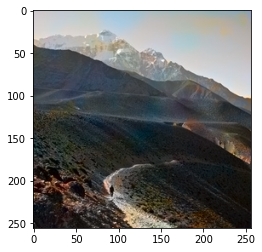

In [24]:
from skimage.color import lab2rgb
from matplotlib.pyplot import imsave,imshow
from PIL import Image


img = load_img('/content/sample_data/Test_images/Test/lFvXyT.jpg', target_size=(256,256))
test_img = img_to_array(np.array(img, dtype=float))
test = test_img/255.0
test = rgb2lab(test)[:,:,0]
test = test.reshape(1,256,256,1)

result = saved_model.predict(test)
result *= 128 #revert ab pixel-scale from -1,1 back to -128,128

pic = np.zeros((256,256,3)) # initialize an empty array for the result image
pic[:,:,0] = test[0][:,:,0] #take the L channel from the input
pic[:,:,1:] = result[0] # take the ab channels from the output
result_pic = lab2rgb(pic)



imshow(result_pic)
imsave("drive/MyDrive/results/mountain.png", result_pic)

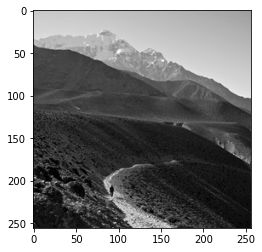

In [25]:
imshow(img)